# Figures / analysis for flat slab paper

In [1]:
%pylab inline
import numpy as np

import seaborn as sns
import glob2
import pandas as pd
import h5py
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
import natsort
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import CubicSpline
import numpy as np
import pint

u = pint.UnitRegistry()

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#dimensionalisation factors

velScale = 3.4482758620689656e-13*(3600*24*365)*100.  #cm/y
timeScale = 8.41e+18/(1e6*3600*24*365)
lengthScale = 2900. #km
stressScale =  11.890606*1e-6   #to MPa

stressScale

1.1890605999999999e-05

## Functions Required

In [3]:
def listify_data(unique_string, path):
    glob_str = path + '*' + unique_string + '*'
    files = natsort.natsort(glob2.glob(glob_str))
    #print(glob_str)
    #return files
    
    dataList = []
    for f in files:
        with h5py.File(f,'r') as hf:
            data = hf.get('data')
            dataList.append(np.array(data))
    return dataList


def get_along_strike(pts):
    dxs = np.diff(pts[:,0])
    dys = np.diff(pts[:,1])
    ds = np.sqrt(dxs**2 + dys**2)
    
    #pad the first point
    return np.append(ds[0], ds) , np.cumsum(np.append([0.], ds)) #front and back pad these arrays


def curvature_splines(x, y):
    """Calculate the signed curvature of a 2D curve at each point
    using interpolating splines.
    Parameters
    ----------
    x,y: numpy.array(dtype=float) shape (n_points, )
    """

    fx = CubicSpline(x, x)
    fy = CubicSpline(x, y)
    #print(np.sqrt(std))

    #x1 = fx.derivative(1)(x)
    #x2 = fx.derivative(2)(x)
    y1 = fy.derivative(1)(x)
    y2 = fy.derivative(2)(x)
    #curvature = (x1* y2 - y1* x2) / np.power(x1** 2 + y1** 2, 1.5)
    curvature = (y2) / np.power(1 + y1** 2, 1.5)

    return curvature, fx, fy, y1

## Setup filter

In [4]:
import scipy.signal as signal
N  = 2    # Filter order
# Cutoff frequency `Wn` is normalized from 0 to 1, 
#where 1 is the Nyquist frequency, pi radians/sample.

#Wn = 0.19 #
#Wn1 = 0.025 #

Wn = 0.26 #
Wn1 = 0.101 #

B, A = signal.butter(N, Wn, output='ba')
B1, A1 = signal.butter(N, Wn1, output='ba')



In [5]:
#87 was the index for the paper figs

i = 87               #timestep to analyse


## Dataframe with plate boundary location

In [6]:
#df.timeAtSave[i]*timeScale

In [7]:
def get_dataframe():
    #file_ = '../models/results/A/20/values/tect_model_data.npz'
    file_ = '../models/results/B/16/values/tect_model_data.npz'
    out = np.load(file_)
    d = dict(out)
    df = pd.DataFrame.from_dict(d)
    return df 

df = get_dataframe()

In [8]:
trenchLoc = (df['(2, 3)'].iloc[i] - 30./lengthScale)*lengthScale
print(trenchLoc)

-510.03650997091023


## Load data

In [9]:
#loads slab midplane points, all timesteps

mppoints = listify_data('midplane**', '../models/results/{}/{}/**/'.format('B', 16))

In [10]:
depthlimit = 1. - (250/2900.)   #depth cutoff (avoids dealing with overturned slab)

In [11]:
#order the data 

indexes = np.argsort(mppoints[i][:,0])
NP = 4    #only us every Nth point
sortedData = mppoints[i].copy()[indexes]
sortedData = sortedData[sortedData[:,1] > depthlimit] #remove deeper points
sortedData = sortedData[sortedData[:,0] > -0.5] #remove points away from the trench
sortedData = sortedData[::NP,:]
ds, ds_cum = get_along_strike(sortedData)
dsMean = ds.mean()


In [12]:
# Second, apply the filter
print(dsMean*lengthScale)
print((1./Wn)*(dsMean*lengthScale))  #wavelength of filter 1
print((1./Wn1)*(dsMean*lengthScale)) #wavelength of filter 2

2.5633726324574764
9.85912550945183
25.379927054034418


# Estimate the curvature, curvature gradient

In [13]:
fy = CubicSpline(sortedData[:,0], sortedData[:,1])

y1_ = fy.derivative(1)(sortedData[:,0])
y2_ = fy.derivative(2)(sortedData[:,0])
c_ = (y2_) / np.power(1 + y1_** 2, 1.5)

c_F = signal.filtfilt(B,A, c_)

dxMean = ds.min()*1

cx_0 = np.gradient(c_, dxMean)
cx_F= signal.filtfilt(B,A, cx_0)
cx_F1= signal.filtfilt(B1,A1, cx_0)

## Plot the curvatire gradient, check filters

Text(-270,5e-11,'($m^{-2}$)')

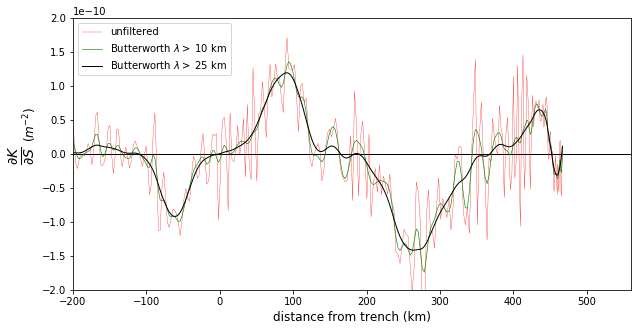

In [14]:
f, ax = plt.subplots(figsize=(10, 5))
ax.plot(sortedData[::1,0]*2900 - trenchLoc, cx_0*(1./2900e3**2),c = 'r', label='unfiltered', lw = 0.3)
ax.plot(sortedData[::1,0]*2900 - trenchLoc, cx_F*(1./2900e3**2), 
        c = 'g', lw = 0.6, label=r'Butterworth $\lambda >$ 10 km')
ax.plot(sortedData[::1,0]*2900 - trenchLoc, cx_F1*(1./2900e3**2), 
        c = 'k', lw = 1, label=r'Butterworth $\lambda >$ 25 km')


ax.set_xlabel('distance from trench (km)', size = 12)
ax.set_ylabel(r'$\frac{\partial{K}}{\partial{S}}$ ', size = 20)


ax.hlines(0, -200, 600, lw=1)
#ax.plot(sortedData[::n,0], cxF)
ax.set_ylim(-2e-10, 2e-10)
ax.set_xlim(-200, 560)
ax.legend(loc = 2)

ax.text(-270, 0.5e-10, r'($m^{-2}$)', size = 12, rotation=90)

In [15]:
#f.savefig('filtering.png', dpi=400, bbox_inches='tight')

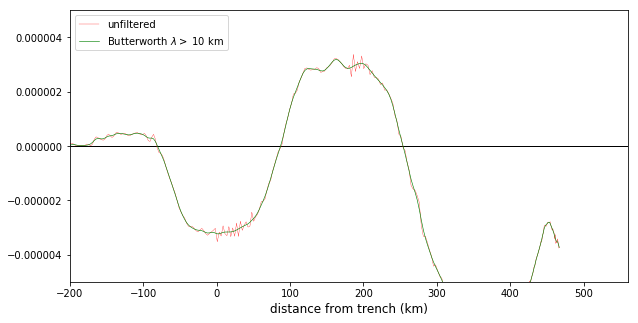

In [16]:
f, ax = plt.subplots(figsize=(10, 5))
ax.plot(sortedData[::1,0]*2900 - trenchLoc, c_*(1./2900e3),c = 'r', label='unfiltered', lw = 0.3)
ax.plot(sortedData[::1,0]*2900 - trenchLoc, c_F*(1./2900e3), 
        c = 'g', lw = 0.6, label=r'Butterworth $\lambda >$ 10 km')



ax.set_xlabel('distance from trench (km)', size = 12)
#ax.set_ylabel(r'$\frac{\partial{K}}{\partial{S}}$ ', size = 20)


ax.hlines(0, -200, 600, lw=1)
#ax.plot(sortedData[::n,0], cxF)
ax.set_ylim(-0.5e-5, 0.5e-5)
ax.set_xlim(-200, 560)
ax.legend(loc = 2)

#ax.text(-270, 0.5e-10, r'($m^{-2}$)', size = 12, rotation=90)

## Save midplane gradient data

In [17]:
midPlaneCurv = np.column_stack( ( 2900.*sortedData[:,0], c_F *(1./2900)  ))
midPlaneCurvGrad = np.column_stack( ( 2900.*sortedData[:,0], cx_F1*(1./2900**2) ))
dimData = np.column_stack(( sortedData[:,0]*2900.0, (1. - sortedData[:,1])*2900.0 ))

#np.savetxt('midPlane.csv', dimData, delimiter=',')
#np.savetxt('curv.csv', midPlaneCurv , delimiter=',')
#np.savetxt('curvGrad.csv', midPlaneCurvGrad, delimiter=',')


In [18]:
#midPlaneCurvGrad.max()

## Load the subduction interface data


In [19]:
## Get / save interface 

interfaceOffsetKm = 7.
ifpoints = listify_data('interface**', '../models/results/{}/{}/**/'.format('B', 16))

indexes = np.argsort(ifpoints[i][:,0])
intData = ifpoints[i].copy()[indexes]


#dimIntData0 = np.column_stack((2900.*intData[:,0], 
#                            2900.*(1. - intData[:,1]) - 0. ))
#dimIntData = np.column_stack((2900.*intData[:,0], 
#                           2900.*(1. - intData[:,1]) - interfaceOffsetKm))





#save dimensional interface data
#np.savetxt('slabTop.csv', dimIntData, delimiter=',')


## Set UW mesh, and load fields

In [20]:
import os

import numpy as np
import underworld as uw
from underworld import function as fn
import glucifer


In [21]:
yres = 192
xres = int(yres  * 6)
elementType = 'Q1/dQ0'



mesh = uw.mesh.FeMesh_Cartesian(elementType = (elementType),
                                 elementRes  = (xres, yres)) 

meshFile = natsort.natsort(glob2.glob('/workspace2/flat_slab/B/16/mesh**.h5'))

mesh.load(meshFile[0])
#Note that when you read in a deformed mesh file, the extents are not correct


scalarField   = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )
tempField   = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )
strainField   = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )


In [22]:
#sigFiles = natsort.natsort(glob2.glob('/workspace2/flat_slab/A/6/sigSS**.h5'))
sigFiles = natsort.natsort(glob2.glob('/workspace2/flat_slab/B/16/sigSS**.h5'))
sfile = sigFiles[i]

#tempFiles = natsort.natsort(glob2.glob('/workspace2/flat_slab/A/6/temp**.h5'))
tempFiles = natsort.natsort(glob2.glob('/workspace2/flat_slab/B/16/temp**.h5'))
tfile = tempFiles[i]

#strain rate 
#eFiles = natsort.natsort(glob2.glob('/workspace2/flat_slab/B/16/eSS**.h5'))
#efile = eFiles[i]
#efile

In [23]:
scalarField.load(sfile)
tempField.load(tfile)
#strainField.load(efile)

In [24]:
#fig = glucifer.Figure(figsize=(960,300) )
#fig.append( glucifer.objects.Surface(mesh, tempField,  onMesh=True))
#fig.append( glucifer.objects.Mesh(mesh))

#fig.show()

## Do slab top properly

In [25]:

import sys

#this does't actually need to be protected. More a reminder it's an interim measure
sys.path.append('../../UWsubduction/')
import UWsubduction as usub

#mesh=None
velocityField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=2)
slabTopI2d = usub.interface2D(mesh, velocityField, intData[:,0], intData[:,1], 1.0, 1.0)

In [26]:
dslength = 7./2900
slabTopRef = slabTopI2d.swarm.particleCoordinates.data[:]
slabTopCorrect = slabTopI2d.swarm.particleCoordinates.data[:] - slabTopI2d.director.data[:]*dslength


dimIntData0 = np.column_stack((2900.*slabTopRef[:,0], 
                            2900.*(1. - slabTopRef[:,1]) - 0. ))
dimIntData = np.column_stack((2900.*slabTopCorrect[:,0], 
                           2900.*(1. - slabTopCorrect[:,1])))





#save dimensional interface data
#np.savetxt('slabTop.csv', dimIntData, delimiter=',')
#np.savetxt('slabTop2.csv', _dimIntData, delimiter=',')
#np.savetxt('slabTop2.csv', _dimIntData, delimiter=',')

In [27]:


dimIntData0 = np.column_stack((2900.*slabTopRef[:,0], 
                            2900.*(1. - slabTopRef[:,1]) - 0. ))
dimIntData = np.column_stack((2900.*slabTopCorrect[:,0], 
                           2900.*(1. - slabTopCorrect[:,1])))


#np.savetxt('slabTop.csv', slabTopCorrect, delimiter=',')

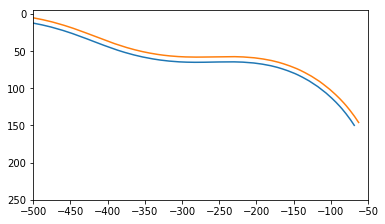

In [202]:
fig, ax = plt.subplots()

ax.plot(dimIntData0[:,0], dimIntData0[:,1])
ax.plot(dimIntData[:,0], dimIntData[:,1])

ax.set_ylim(250, -5)
ax.set_xlim(-500, -50)
ax.set_aspect('equal')

## Load earthquake data

In [29]:
dfEQ = pd.read_csv('./analysis_data/pps.csv')
dfEQW = dfEQ[dfEQ.sector == 'western'].copy()
dfEQW['mNorm'] = (dfEQW.m - dfEQW.m.min())/(dfEQW.m.max()- dfEQW.m.min())
dfEQE = dfEQ[dfEQ.sector == 'eastern']

dfCMT_EHB = np.loadtxt('./intraSlabEqsMex', delimiter=',')


dfEQ.head(3)

,id,distance,adj.depth,depth,m,temp,adj.temp,stress,adj.stress,sector
0,1,102.327159,-35.000000,-35.0,5.5,224.12,224.12,-0.15,-0.15,eastern
1,2,104.339079,-35.000000,-35.0,5.5,219.20,219.20,0.08,0.08,eastern
2,3,247.412883,-84.265221,-79.0,5.0,673.72,805.78,95.78,-80.86,western


In [30]:
#dfCMT_EHB.shape

(80, 0)

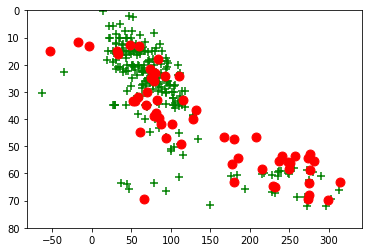

In [31]:
fig, ax = plt.subplots()
ax.scatter(dfEQ.distance, -1.*dfEQ['adj.depth'], c='g', marker='+', s =80, label = 'earthquakes' )

ax.scatter(dfCMT_EHB[:,0], dfCMT_EHB[:,1], c='r', marker='o', s =80, label = 'earthquakes' )

ax.set_ylim(80, 0)

## Load fields

In [100]:
hf = h5py.File('./analysis_data/mesh.h5', 'r')
meshData = np.array(hf.get("vertices"))

hf = h5py.File('./analysis_data/temp_2200.h5', 'r')
tempData = np.array(hf.get("data"))

hf = h5py.File('./analysis_data/sigSS_2200.h5', 'r')
stressData = np.array(hf.get("data"))

hf = h5py.File('./analysis_data/midplane02200.h5', 'r')
midplaneData = np.array(hf.get("data"))

hf = h5py.File('./analysis_data/interface02200.h5', 'r')
interfaceData = np.array(hf.get("data"))

hf = h5py.File('./analysis_data/sigII2_2202.h5', 'r')
stressInvData = np.array(hf.get("data"))

hf = h5py.File('./analysis_data/eSS_2202.h5', 'r')
strainData = np.array(hf.get("data"))

hf = h5py.File('./analysis_data/eig_2202.h5', 'r')
eigData = np.array(hf.get("data"))

hf = h5py.File('./analysis_data/eII_2202.h5', 'r')
strainInvData = np.array(hf.get("data"))

hf = h5py.File('./analysis_data/visc_2202.h5', 'r')
viscData = np.array(hf.get("data"))

#this one was sourced from the checkpoint
hf = h5py.File('./analysis_data/pressureField.h5', 'r')
pressData = np.array(hf.get("data"))

In [101]:
#interp pressure onto P1 mesh
pressureOnMesh = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
pressureField   = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
pressureField.data[:,0] = pressData[:,0]
proj = uw.utils.MeshVariable_Projection(pressureOnMesh, pressureField)
proj.solve()

In [102]:
tempScale = 1400.
stressData[tempData*tempScale  > 1270] = 0.0

In [35]:
#natsort.natsort(glob2.glob('../models/results/B/16/files/midplane**'))[87]

## Plot temp, multiple timesteps

In [41]:
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from matplotlib import  ticker


In [ ]:
#np.arange(8, 56,8)

times = [1, 3, 6, 13, 22, 27]

tempLevels = [0.0, 200.0, 400.0, 600.0, 800.0, 1000.0, 1250.0, 1410.0]

# Four axes, returned as a 2-d array
#f, axarr = plt.subplots(3, 2)
#f.tight_layout()
f = plt.figure(figsize = (7.25,6))
gs1 = gridspec.GridSpec(3, 2)
gs1.update(wspace=0.05, hspace=0.025)


count = 0
for i in [2, 10, 25, 50, 75, 87]:
    tfile = tempFiles[i]
    #tempField.load(tfile)
    #tempdata = tempField.evaluate(coords[:, :])[:,0]
    #build array to collect the data
    #temp = np.zeros(xv.shape) 
    #temp[:] = np.flipud(tempdata.reshape((xv.shape)))*1400.0
    
    hf = h5py.File(tfile, 'r')
    tempData = np.array(hf.get("data"))
    
    
    ax = plt.subplot(gs1[count])
    #plt.subplot(gs1[i])

    
    cb2 = ax.tricontourf((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
                   tempScale*tempData[:,0],
                          vmax = 1400, vmin = 0.,
                          levels=tempLevels, cmap='coolwarm', alpha=0.8)

    ax.tricontour((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
                   tempScale*tempData[:,0], levels = [600, 1250], colors= 'k', linewidths = 1. )

    ax.hlines(660, -1000, 1200,  alpha = 0.5 , linewidths = 1 )

    ax.set_xlim(-500, 1100)
    ax.set_ylim(800, 0)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    #print(count)
    ax.text(-475, 770,'{} myr'.format(times[count]), size = 10)
    count += 1


In [ ]:
#f.savefig('evolution.png', dpi=300, bbox_inches='tight')

## Plot resolved stress, curvature etc.

In [36]:
indexWedge = np.argmin(np.abs(dimIntData[:,1] - 45)) #this determines where the LVW intersects the subduction interface


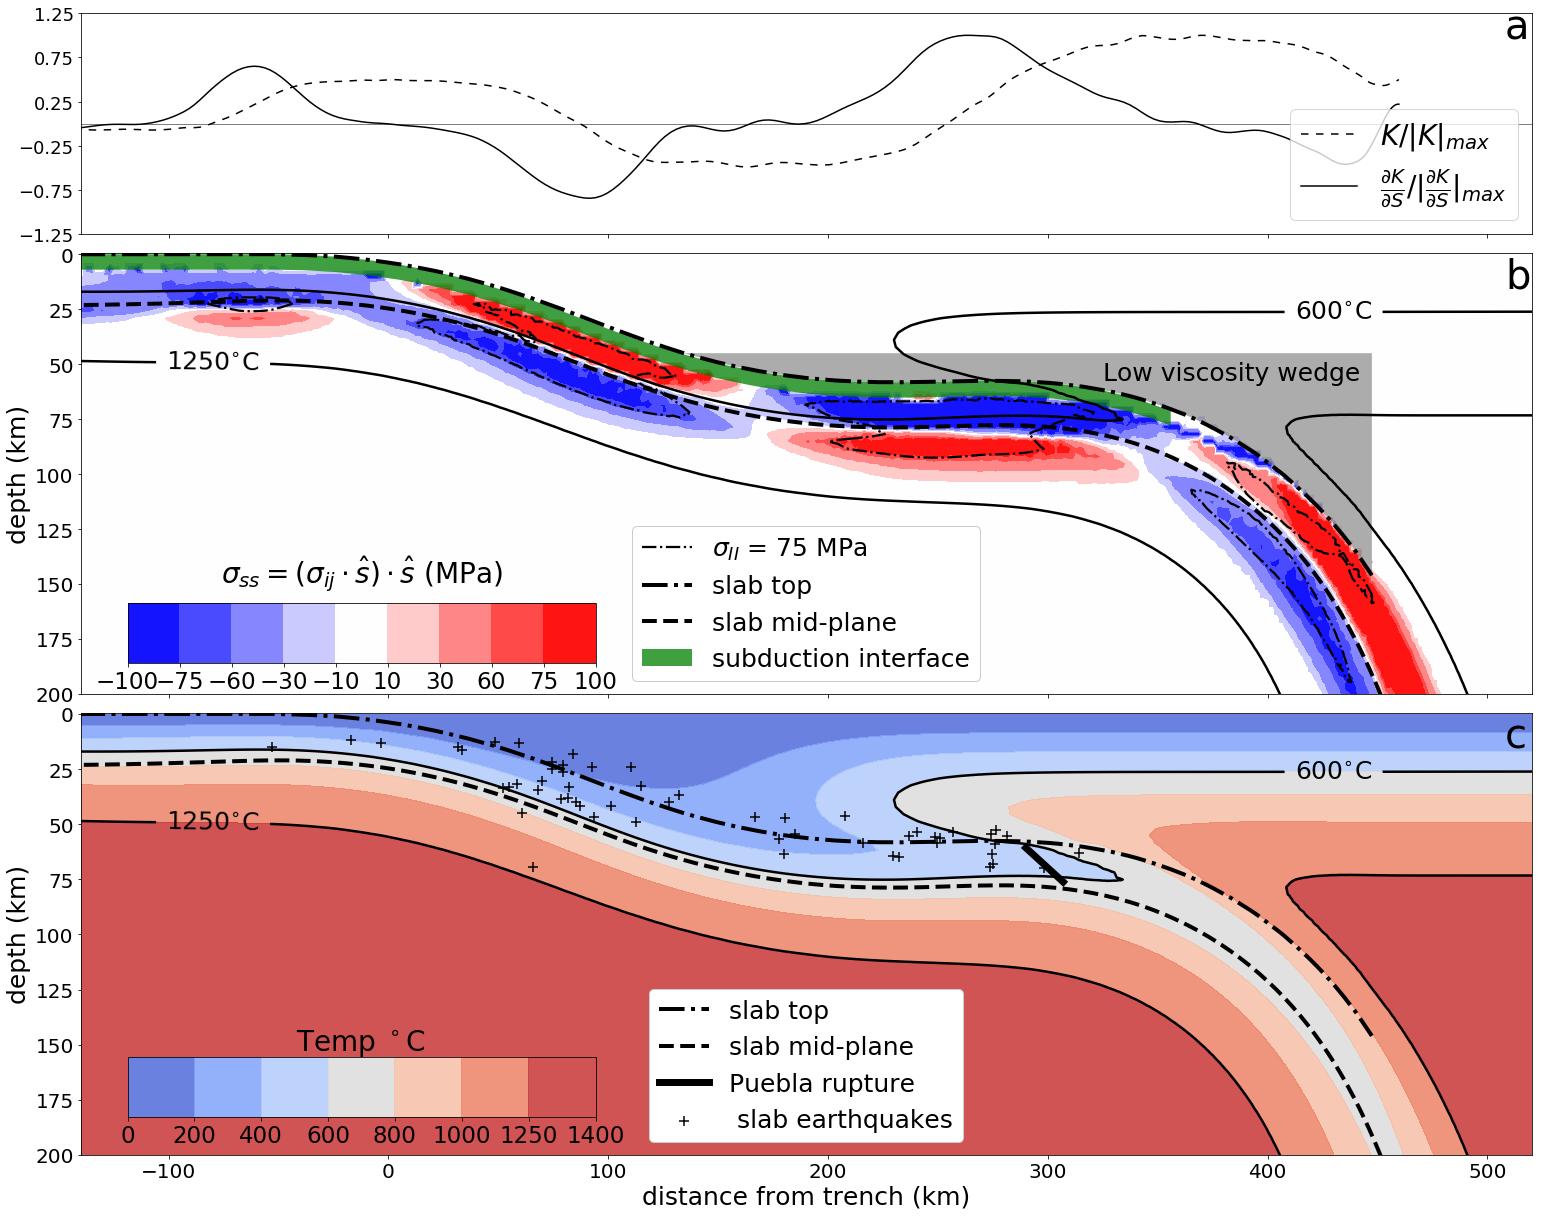

In [226]:
# plot it

tempLevels = [    0.,   200.,   400.,   600.,   800.,  1000.,  1250.,  1400.]
stressLevels = [-100.,  -75.,  -60.,  -30.,  -10, 10,  30.,   60.,   75.,  100.]


fig = plt.figure(figsize=(26, 21)) 
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 2, 2]) 
gs.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

########################



ax0 = plt.subplot(gs[0])

#ax0.plot(2900.*sortedData[:-10],(y2/abs(y2.max()))[:-10] , c= 'k', ls = '--', 
#         label = r'$\frac{K_{,s}}{K_{,s_{max}}}$', lw = 2)

blok = -10
blok1 = 50
blok2 = -50

ax0.plot( 2900.*sortedData[::1,0][:blok ] - trenchLoc, -1.*c_F[:blok ]/np.abs(c_F[blok1:blok2]).max() , 
         c = 'k',ls = '--', dashes = (5,5), label = r'$K/\left|K\right|_{max}$' )

ax0.plot( 2900.*sortedData[::1,0][:blok ] - trenchLoc, -1.*cx_F1[:blok ]/np.abs(cx_F1[blok1:blok2]).max() ,  
         c = 'k', label = r'$ \frac{ \partial{K}  }{ \partial{S}} / \left|\frac{ \partial{K}  }{ \partial{S}}\right|_{max} $' )


ax0.hlines(0 , -650. -  trenchLoc, 10. - trenchLoc, linewidths = 0.5)
ax0.set_xlim(-650. - trenchLoc, 10. - trenchLoc)
ax0.set_ylim(-1.1, 1.1)
ax0.set_yticks(ax0.get_yticks()[::2])

ax0.tick_params(labelsize=15)



#ax0.ticklabel_format(style='sci',axis='y', scilimits=(0,0))

ax0.legend(loc=4, fontsize = 28)

#ax0.set_yticklabels([])
ax0.set_xticklabels([])
#ax0.grid(False)

########################
ax1 = plt.subplot(gs[1])



tempScale= 1400.0
levels=np.linspace(0., tempScale + 5, 10, endpoint=True)

cb = ax1.tricontourf((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  -1.*stressData[:,0]*stressScale, 
                vmax = 95, vmin = -95,
                levels = stressLevels, cmap='bwr')

#cb = ax1.tricontourf((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
#                -1.*np.sign(strainData[:,0])*stressInvData[:,0]*stressScale, 
#                vmax = 99, vmin = -99,
#                    levels=stressLevels,
#                    cmap='seismic_r', alpha=0.5)


CS = ax1.tricontour((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
               tempScale*tempData[:,0], levels = [600, 1250], colors= 'k', linewidths = 2.5 )

CS_ = ax1.tricontour((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
               stressScale*stressInvData[:,0],  levels = [75], colors= 'k', linewidths = 2.25, linestyles='-.' )
ax1.plot([-1000, -1001],[1000, 1001], label = r'$\sigma_{II}$ = 75 MPa',c= 'k', lw = 2.25, ls='-.'   )



#cl_ = ax1.clabel(CS_, fontsize=10, inline=1, fmt='%1.0f' + r'$\sigma_{II}$ MPa', 
#           manual=[(50,70),], inline_spacing=1)


#cl = ax1.clabel(CS, fontsize=15, inline=1, fmt='%1.0f' + ' C', 
#           manual=[(-80,70),(430, 30)], inline_spacing=-15)


#ax1.plot(2900.*sortedData[:,0] - trenchLoc, 2900 - 2900.*sortedData[:,1], 
#         c= 'k', ls = '--', lw = 4, label = 'slab mid-plane')


#mask = dimData0[:,1] < 90.
mask = dimIntData0[:,1] <78.

#ax1.plot(dimIntData[:,0] - trenchLoc, dimIntData[:,1],c= 'k', ls = '--', lw= 2)
#ax1.plot(dimIntData0[:,0] - trenchLoc, dimIntData0[:,1], c = 'k', lw= 2)

ax1.fill_between(dimIntData0[mask,0] - trenchLoc, dimIntData0[mask,1]  , 
                 dimIntData[mask,1], facecolor='green', alpha=0.75, label = 'subduction interface')

ax1.fill_between(dimIntData[indexWedge:,0] - trenchLoc, 
                 dimIntData[indexWedge:,1], 45*np.ones(len(dimIntData[indexWedge:,1])), 
                 facecolor='gray', alpha=0.65) 


#ax1.hlines(75, -650 - trenchLoc, 10 - trenchLoc)
ax1.set_xlim(-650 - trenchLoc, 10 - trenchLoc)
ax1.set_ylim(200, -0.5)

ax1.set_ylabel('depth (km)', size = 25)
ax1.grid(False)
ax1.tick_params(labelsize=15)

cl = ax1.clabel(CS, fontsize=25, inline=1, fmt='%1.0f' + r'$^{\circ}$C', 
           manual=[(-80,70),(430, 30)], inline_spacing=10)


ax1.text(325, 57,'Low viscosity wedge', size = 25)


#top of slab
ax1.plot(dimIntData[:,0] - trenchLoc, dimIntData[:,1],c= 'k', ls = '-.', lw= 4, label='slab top')

ax1.plot(2900.*sortedData[:,0] - trenchLoc, 2900 - 2900.*sortedData[:,1], 
         c= 'k', ls = '--', lw = 4, label = 'slab mid-plane')

#ax1.text(220, 110, r'$\sigma_{II}$ = 80 MPa', size = 22)


# Now adding the colorbar
#cbaxes = fig.add_axes([0.14, 0.18, 0.4, 0.05]) 
cbaxes = fig.add_axes([0.15, 0.45, 0.25, 0.04]) 

cb1 = colorbar(cb, cax = cbaxes, orientation="horizontal") 
cb1.set_label(r'$\sigma_{ss} =  (\sigma_{ij} \cdot \hat s)\cdot \hat s$ (MPa)', size= 28, labelpad=-140)
#cb1.set_label(r'$\sigma_{II}$ (signed)', size= 28, labelpad=-140)
cb1.set_ticks(stressLevels[:])
cbaxes.tick_params(labelsize=23)

#labels = cbaxes.get_xticklabels() 
#for label in labels: 
#    label.set_rotation(0)
#    label.set_fontsize(23)

ax1.set_aspect('equal')
ax1.set_xticklabels([])

leg1 = ax1.legend(loc = 8, fontsize = 25)
leg1.get_frame().set_alpha(1.0)

#ax 3

ax2 = plt.subplot(gs[2])

cb2 = ax2.tricontourf((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
               tempScale*tempData[:,0],
                      vmax = 1400, vmin = 0.,
                      levels=tempLevels, cmap='coolwarm', alpha=0.85)

CS2 = ax2.tricontour((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
               tempScale*tempData[:,0], levels = [600, 1250], colors= 'k', linewidths = 2.5 )




#c2 = ax2.clabel(CS2, fontsize=15, inline=1, fmt='%1.0f' + ' C', 
#           manual=[(-80,70),(430, 30)], inline_spacing=-15)

#these ones for saving the contours in original reference frame
#CS2 = ax2.tricontour((2900*meshData[:,0]), 2900*(1. - meshData[:,1]),  
#               tempScale*tempData[:,0], levels = [650, 1250], colors= 'k', linewidths = 2.5 )




cbaxes2 = fig.add_axes([0.15, 0.15, 0.25, 0.04]) 

cb2 = colorbar(cb2, cax = cbaxes2, orientation="horizontal") 
cb2.set_label(r'Temp $^\circ$C ', size= 28, labelpad=-120)
cbaxes2.tick_params(labelsize=15)
#duplicate?
labels = cbaxes2.get_xticklabels() 
for label in labels: 
    label.set_rotation(0)
    label.set_fontsize(23)

#cb2.set_ticks(stressLevels[:])

#top of slab
ax2.plot(dimIntData[:,0] - trenchLoc, dimIntData[:,1],c= 'k', ls = '-.', lw= 4, label='slab top')

ax2.plot(2900.*sortedData[:,0] - trenchLoc, 2900 - 2900.*sortedData[:,1], 
         c= 'k', ls = '--', lw = 4, label = 'slab mid-plane')


#290 -60.76315
#313 -76.26315
#puebla approx
#ax2.plot([290,305], [56,71], lw = 7, c='k')
ax2.plot([290,307], [60.7,76.2], lw = 7, c='k', label='Puebla rupture')

#EARTHQUAKES
#ax2.scatter(dfEQ.distance, -1.*dfEQ['adj.depth'], c='g', marker='+', s =80, label = 'earthquakes' )
#ax2.scatter(dfEQ.distance, -1.*dfEQE['adj.depth'], c='g', marker='o', s =60, label = 'eqs. eastern MFS'  )

ax2.scatter(dfCMT_EHB[:,0], dfCMT_EHB[:,1], c='k', marker='+', s =85, label = ' slab earthquakes' )



leg = ax2.legend(loc = 8, fontsize = 25)
leg.get_frame().set_alpha(1.0)


ax2.set_xlim(-650 - trenchLoc, 10 - trenchLoc)
ax2.set_ylim(200, -0.5)
ax2.set_xlabel('distance from trench (km)', size = 25)
ax2.set_ylabel('depth (km)', size = 25)
ax2.grid(False)
ax2.tick_params(labelsize=15)


c2 = ax2.clabel(CS2, fontsize=25, inline=1, fmt='%1.0f' + r'$^{\circ}$C', 
           manual=[(-80,70),(430, 30)], inline_spacing=10)


ax0.text(508, 0.96, 'a', size = 40)
ax1.text(508, 15, 'b', size = 40)
ax2.text(508, 15, 'c', size = 40)

ax0.yaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=20)
ax2.xaxis.set_tick_params(labelsize=20)
ax2.yaxis.set_tick_params(labelsize=20)

In [41]:
#fig.savefig('stress_curv_3panel.png', dpi=300, bbox_inches='tight')

## Save Contours

In [36]:
#p = CS2.collections[0].get_paths()
#pv = [path.vertices for path in p]
#out = np.concatenate(pv) #already dimensionalized
#np.savetxt('650C_contour.csv', out , delimiter=',')

#fig, ax = plt.subplots(figsize=(10,5))
#ax.scatter(out[:,0] , out[:,1])
#ax.set_xlim(-600, 200)
#ax.set_ylim(800, 0)
#ax.set_aspect('equal')

## KdTree Mask and slab masking

Set up a mask based on distance from the midplane, to help create images that just capture the slab

In [47]:
from scipy.spatial import KDTree

In [48]:
#I'm goint want a line that is beneath the original midplane coords. 

midPlaneCorrect_ = usub.interface2D(mesh, velocityField, sortedData[:,0], sortedData[:,1], 1.0, 1.0)
dslength = 12./2900
midPlanRef = midPlaneCorrect_.swarm.particleCoordinates.data[:]
midPlaneCorrect = midPlaneCorrect_.swarm.particleCoordinates.data[:] + midPlaneCorrect_.director.data[:]*dslength

In [49]:
#Setup the KdTree. Do this in the model/UWCoords

tree = KDTree(midPlaneCorrect[::5]) #can afford to lose a few points here
dist,  pts = tree.query(np.column_stack((meshData[:,0], meshData[:,1])))

distMask = dist*2900. > 30.

In [156]:
## Isotherm mask

contour = np.loadtxt('1250C_contour.csv', delimiter=',')
cmask = np.logical_and(contour[:,0] - trenchLoc > -150, contour[:,0] - trenchLoc <600)
contour = contour[cmask]

In [139]:
#mask the strainRate

truncStrain = np.abs(strainInvData.copy()) 
#truncStrain[truncStrain > 2e4] = 1.99e4
#truncStrain[truncStrain < 1] = 1

truncStrain[:,0][distMask] = 0

truncResStrain = strainData.copy()
truncResStrain[:,0][distMask] = 0


#manually truncate the viscosity data

viscData[viscData[:,0] < 1.1] = 1.1
viscData[viscData[:,0] >= 7e3] = 7e3
viscData.min(), viscData.max()


#this mask is used with eigenvectors
tempMask = tempScale*tempData[:,0] < 1250.
#this is how many (nth) eigenvectors to plot
qn = 6


#Normalise strain rates at 1e-15
strainRateScale = 1./8.41e+18   
strainRateScale
srfixscale = (strainRateScale/1e-15)

In [104]:
#truncResStrain.min()

In [105]:
truncStrain.min(), truncStrain.max()

(0.0, 2428128.8591098348)

srLevels = np.array([0.0001, 500,  1000,  2500, 5000,7500,  1e4])*strainRateScale

def Round_To_n(x, n):
    l = []
    for x_ in x:
        out =  round(x_, -int(np.floor(np.sign(x_) * np.log10(abs(x_)))) + n)
        l.append(out)
    return l

Round_To_n(srLevels,2)

Text(0.21,0.24,'$(s^{-1}\\times 10^{-15})$')

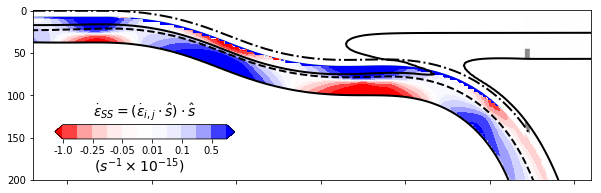

In [220]:
fig, ax0 = plt.subplots(figsize=(10, 4)) 

########################


#srLevels = np.round(np.array([0., 500,  1000,  2500, 5000,7500,  1e4])*srfixscale, 2)
#srLevels2 = np.append((-1*srLevels)[::-1], srLevels)

#these are normalised to 1e-15
srLevels = np.array([ 1e-02,5e-02, 1e-01,  2.5e-01, 5e-01,  1e+00])
#srLevels2 = np.append((-1*srLevels)[::-1], np.append([0], srLevels))
srLevels2 = np.append((-1*srLevels)[::-1],  srLevels)

cb0 = ax0.tricontourf((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
                truncResStrain[:,0]*srfixscale ,
                #vmin =1*srfixscale, vmax=1e4*srfixscale,
                levels = srLevels2,
                cmap='bwr_r', extend = 'both')  
                    #norm = LogNorm())


mask = dimIntData0[:,1] <78.

ax0.fill_between(dimIntData0[mask,0] - trenchLoc, dimIntData0[mask,1]  , 
                 dimIntData[mask,1], facecolor='green', alpha=0.75, label = 'subduction interface')

ax0.fill_between(dimIntData[indexWedge:,0] - trenchLoc, 
                 dimIntData[indexWedge:,1], 45*np.ones(len(dimIntData[indexWedge:,1])), 
                 facecolor='gray', alpha=0.9) 

#top of slab
ax0.plot(dimIntData[:,0] - trenchLoc, dimIntData[:,1],c= 'k', ls = '-.', lw= 2, label='slab top')

ax0.plot(2900.*sortedData[:,0] - trenchLoc, 2900 - 2900.*sortedData[:,1], 
         c= 'k', ls = '--', lw = 2, label = 'slab mid-plane')

CS = ax0.tricontour((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
               tempScale*tempData[:,0], levels = [600, 1100], colors= 'k', linewidths = 2.0 )



ax0.fill_between(contour[:,0] - trenchLoc, contour[:,1]  , 
                 200.*np.ones(len(contour[:,1])), facecolor='w', alpha=1)


ax0.fill_between(dimIntData0[:,0] - trenchLoc, dimIntData0[:,1]  , 
                 np.zeros(len(dimIntData[:,1])), facecolor='w', alpha=1)


#ax1.hlines(75, -650 - trenchLoc, 10 - trenchLoc)
ax0.set_xlim(-650 - trenchLoc, 10 - trenchLoc)
ax0.set_ylim(200, -0.5)

ax0.set_aspect('equal')
ax0.set_xticklabels([])


#cbaxes = fig.add_axes([0.4, 0.4, 0.1, 0.1], zorder = 1000) 
cbaxes = fig.add_axes([0.155, 0.35, 0.25, 0.05]) 
cb = colorbar(cb0, cax = cbaxes, orientation="horizontal") 
cb.set_ticks(srLevels2[::2])
cb.set_ticklabels(srLevels2[::2])
cb.set_label(r'$\dot \epsilon_{SS} = (\dot \epsilon_{i,j}\cdot \hat s) \cdot \hat s $', size= 14, labelpad=-55)
fig.text(0.21, 0.24,  r'$(s^{-1}\times 10^{-15})$', fontsize= 12)


#$\sigma_{ss} =  (\sigma_{ij} \cdot \hat s)\cdot \hat s$

#cbaxes.tick_params(labelsize=5)


In [206]:
srLevels2

array([-1.  , -0.5 , -0.25, -0.1 , -0.05, -0.01,  0.01,  0.05,  0.1 ,
        0.25,  0.5 ,  1.  ])

In [184]:
#p = CS.collections[0].get_paths()
#pv = [path.vertices for path in p]
#out = np.concatenate(pv) #already dimensionalized
#np.savetxt('1100C_contour.csv', out , delimiter=',')

In [200]:
#Use a differnet contour to mask the strain rate

contour = np.loadtxt('1100C_contour.csv', delimiter=',')
#cmask = np.logical_and(contour[:,0] - trenchLoc > -250, contour[:,0] - trenchLoc <600)
#contour = contour[cmask]

## Big Fig strain rate, 

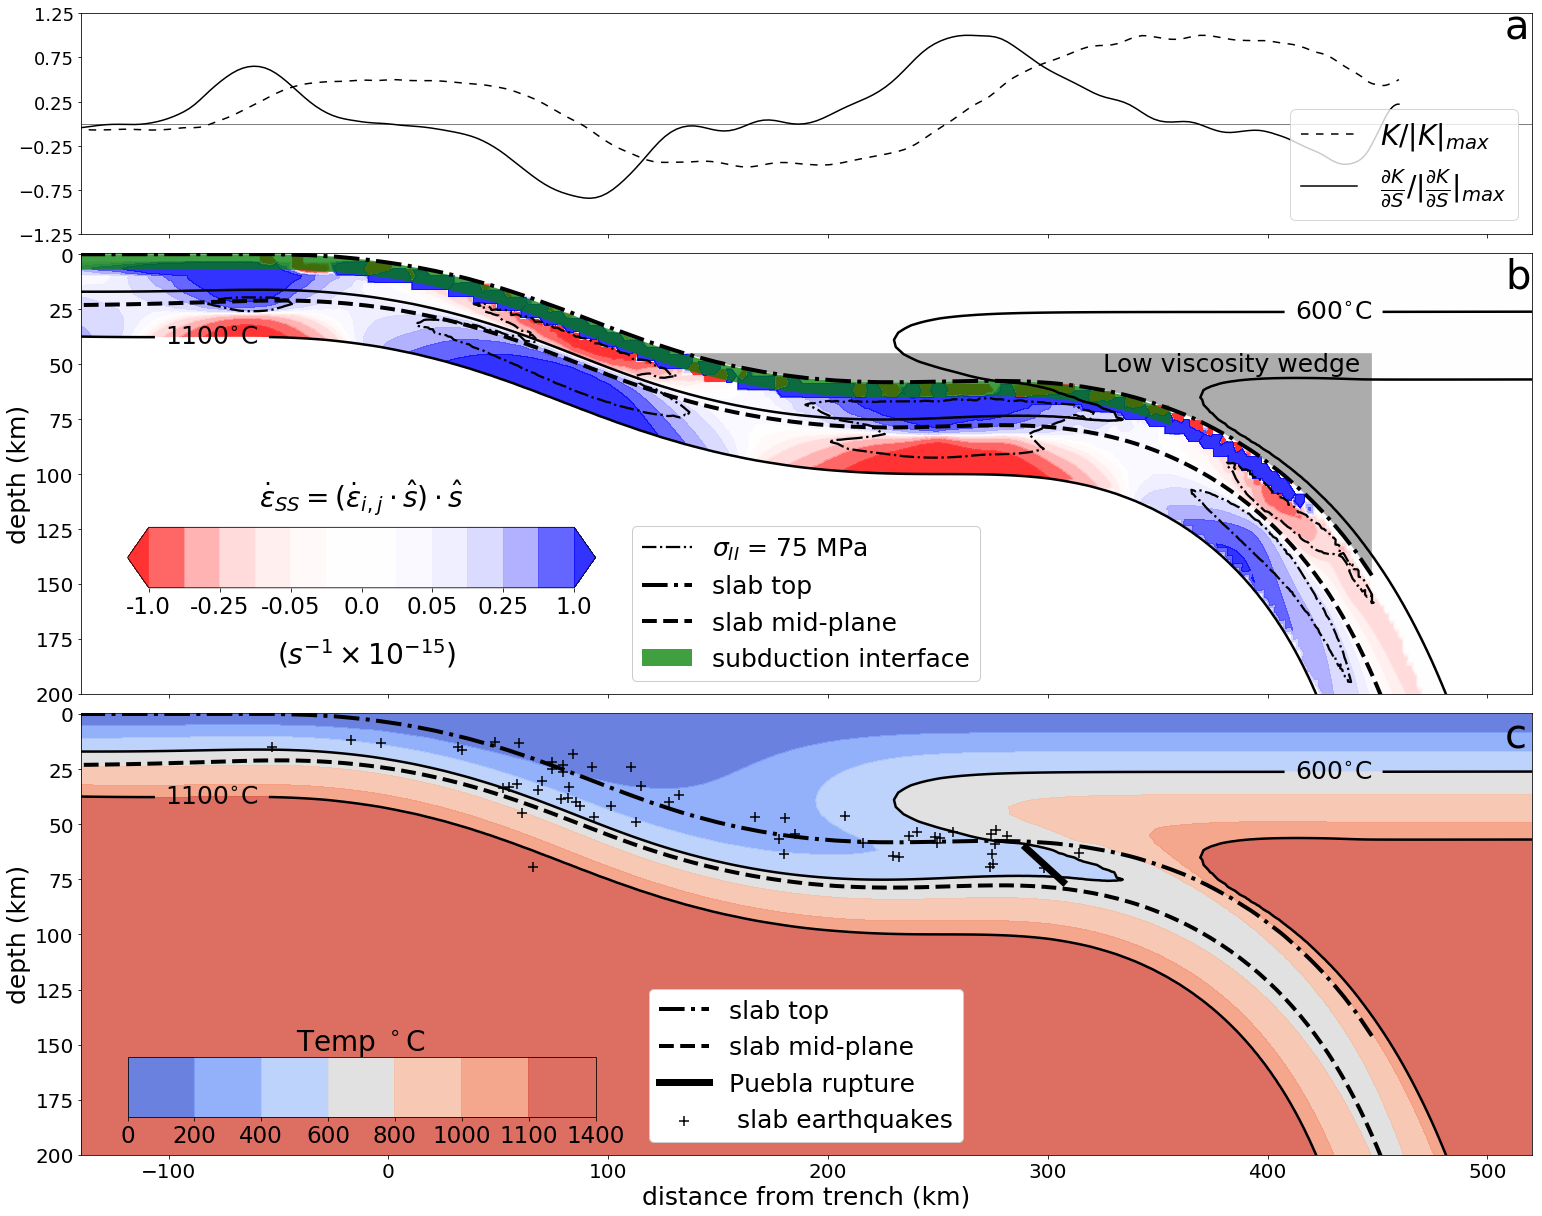

In [227]:

# plot it

tempLevels = [    0.,   200.,   400.,   600.,   800.,  1000.,  1100.,  1400.]
stressLevels = [-100.,  -75.,  -60.,  -30.,  -10, 10,  30.,   60.,   75.,  100.]
srLevels = np.array([ 1e-02,5e-02, 1e-01,  2.5e-01, 5e-01,  1e+00])
srLevels2 = np.append((-1*srLevels)[::-1], np.append([0], srLevels))

fig = plt.figure(figsize=(26, 21)) 
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 2, 2]) 
gs.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

########################



ax0 = plt.subplot(gs[0])

#ax0.plot(2900.*sortedData[:-10],(y2/abs(y2.max()))[:-10] , c= 'k', ls = '--', 
#         label = r'$\frac{K_{,s}}{K_{,s_{max}}}$', lw = 2)

blok = -10
blok1 = 50
blok2 = -50

ax0.plot( 2900.*sortedData[::1,0][:blok ] - trenchLoc, -1.*c_F[:blok ]/np.abs(c_F[blok1:blok2]).max() , 
         c = 'k',ls = '--', dashes = (5,5), label = r'$K/\left|K\right|_{max}$' )

ax0.plot( 2900.*sortedData[::1,0][:blok ] - trenchLoc, -1.*cx_F1[:blok ]/np.abs(cx_F1[blok1:blok2]).max() ,  
         c = 'k', label = r'$ \frac{ \partial{K}  }{ \partial{S}} / \left|\frac{ \partial{K}  }{ \partial{S}}\right|_{max} $' )


ax0.hlines(0 , -650. -  trenchLoc, 10. - trenchLoc, linewidths = 0.5)
ax0.set_xlim(-650. - trenchLoc, 10. - trenchLoc)
ax0.set_ylim(-1.1, 1.1)
ax0.set_yticks(ax0.get_yticks()[::2])

ax0.tick_params(labelsize=15)



#ax0.ticklabel_format(style='sci',axis='y', scilimits=(0,0))

ax0.legend(loc=4, fontsize = 28)

#ax0.set_yticklabels([])
ax0.set_xticklabels([])
#ax0.grid(False)

########################
ax1 = plt.subplot(gs[1])



tempScale= 1400.0
levels=np.linspace(0., tempScale + 5, 10, endpoint=True)

#cb = ax1.tricontourf((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  -1.*stressData[:,0]*stressScale, 
#                vmax = 95, vmin = -95,
#                levels = stressLevels, cmap='bwr')

#cb = ax1.tricontourf((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
#                -1.*np.sign(strainData[:,0])*stressInvData[:,0]*stressScale, 
#                vmax = 99, vmin = -99,
#                    levels=stressLevels,
#                    cmap='seismic_r', alpha=0.5)

cb = ax1.tricontourf((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
                truncResStrain[:,0]*srfixscale ,
                #vmin =1*srfixscale, vmax=1e4*srfixscale,
                levels = srLevels2,
                cmap='bwr_r', extend = 'both', alpha = 0.8)  
                    #norm = LogNorm())
    
    

ax1.fill_between(contour[:,0] - trenchLoc, contour[:,1]  , 
                 200.*np.ones(len(contour[:,1])), facecolor='w', alpha=1)


#ax1.fill_between(dimIntData0[:,0] - trenchLoc, dimIntData0[:,1]  , 
#                 np.zeros(len(dimIntData[:,1])), facecolor='w', alpha=1)


CS = ax1.tricontour((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
               tempScale*tempData[:,0], levels = [600, 1100], colors= 'k', linewidths = 2.5 )

CS_ = ax1.tricontour((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
               stressScale*stressInvData[:,0],  levels = [75], colors= 'k', linewidths = 2.25, linestyles='-.' )
ax1.plot([-1000, -1001],[1000, 1001], label = r'$\sigma_{II}$ = 75 MPa',c= 'k', lw = 2.25, ls='-.'   )



#cl_ = ax1.clabel(CS_, fontsize=10, inline=1, fmt='%1.0f' + r'$\sigma_{II}$ MPa', 
#           manual=[(50,70),], inline_spacing=1)


#cl = ax1.clabel(CS, fontsize=15, inline=1, fmt='%1.0f' + ' C', 
#           manual=[(-80,70),(430, 30)], inline_spacing=-15)


#ax1.plot(2900.*sortedData[:,0] - trenchLoc, 2900 - 2900.*sortedData[:,1], 
#         c= 'k', ls = '--', lw = 4, label = 'slab mid-plane')


#mask = dimData0[:,1] < 90.
mask = dimIntData0[:,1] <78.

#ax1.plot(dimIntData[:,0] - trenchLoc, dimIntData[:,1],c= 'k', ls = '--', lw= 2)
#ax1.plot(dimIntData0[:,0] - trenchLoc, dimIntData0[:,1], c = 'k', lw= 2)

ax1.fill_between(dimIntData0[mask,0] - trenchLoc, dimIntData0[mask,1]  , 
                 dimIntData[mask,1], facecolor='green', alpha=0.75, label = 'subduction interface')

ax1.fill_between(dimIntData[indexWedge:,0] - trenchLoc, 
                 dimIntData[indexWedge:,1], 45*np.ones(len(dimIntData[indexWedge:,1])), 
                 facecolor='gray', alpha=0.65) 


#ax1.hlines(75, -650 - trenchLoc, 10 - trenchLoc)
ax1.set_xlim(-650 - trenchLoc, 10 - trenchLoc)
ax1.set_ylim(200, -0.5)

ax1.set_ylabel('depth (km)', size = 25)
ax1.grid(False)
ax1.tick_params(labelsize=15)

cl = ax1.clabel(CS, fontsize=25, inline=1, fmt='%1.0f' + r'$^{\circ}$C', 
           manual=[(-80,70),(430, 30)], inline_spacing=10)


ax1.text(325, 53,'Low viscosity wedge', size = 25)


#top of slab
ax1.plot(dimIntData[:,0] - trenchLoc, dimIntData[:,1],c= 'k', ls = '-.', lw= 4, label='slab top')

ax1.plot(2900.*sortedData[:,0] - trenchLoc, 2900 - 2900.*sortedData[:,1], 
         c= 'k', ls = '--', lw = 4, label = 'slab mid-plane')

#ax1.text(220, 110, r'$\sigma_{II}$ = 80 MPa', size = 22)


# Now adding the colorbar
#cbaxes = fig.add_axes([0.14, 0.18, 0.4, 0.05]) 
#cbaxes = fig.add_axes([0.15, 0.45, 0.25, 0.04]) 
#cb1 = colorbar(cb, cax = cbaxes, orientation="horizontal") 
#cb1.set_label(r'$\sigma_{ss} =  (\sigma_{ij} \cdot \hat s)\cdot \hat s$ (MPa)', size= 28, labelpad=-140)
#cb1.set_label(r'$\sigma_{II}$ (signed)', size= 28, labelpad=-140)
#cb1.set_ticks(stressLevels[:])
#cbaxes.tick_params(labelsize=23)



cbaxes = fig.add_axes([0.15, 0.5, 0.25, 0.04]) 
cb1 = colorbar(cb, cax = cbaxes, orientation="horizontal") 
cb1.set_ticks(srLevels2[::2])
cb1.set_ticklabels(srLevels2[::2])
#cb1.set_label(r'$\dot \epsilon_{SS} (s^{-1}\times 10^{-15})$', size= 28, labelpad=-140)
cb1.set_label(r'$\dot \epsilon_{SS} = (\dot \epsilon_{i,j}\cdot \hat s) \cdot \hat s $', size= 28, labelpad=-140)
fig.text(0.23, 0.45,  r'$(s^{-1}\times 10^{-15})$', fontsize= 28)

cbaxes.tick_params(labelsize=23)

#labels = cbaxes.get_xticklabels() 
#for label in labels: 
#    label.set_rotation(0)
#    label.set_fontsize(23)

ax1.set_aspect('equal')
ax1.set_xticklabels([])

leg1 = ax1.legend(loc = 8, fontsize = 25)
leg1.get_frame().set_alpha(1.0)

#ax 3

ax2 = plt.subplot(gs[2])

cb2 = ax2.tricontourf((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
               tempScale*tempData[:,0],
                      vmax = 1400, vmin = 0.,
                      levels=tempLevels, cmap='coolwarm', alpha=0.85)

CS2 = ax2.tricontour((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
               tempScale*tempData[:,0], levels = [600, 1100], colors= 'k', linewidths = 2.5 )






#c2 = ax2.clabel(CS2, fontsize=15, inline=1, fmt='%1.0f' + ' C', 
#           manual=[(-80,70),(430, 30)], inline_spacing=-15)

#these ones for saving the contours in original reference frame
#CS2 = ax2.tricontour((2900*meshData[:,0]), 2900*(1. - meshData[:,1]),  
#               tempScale*tempData[:,0], levels = [650, 1250], colors= 'k', linewidths = 2.5 )




cbaxes2 = fig.add_axes([0.15, 0.15, 0.25, 0.04]) 

cb2 = colorbar(cb2, cax = cbaxes2, orientation="horizontal") 
cb2.set_label(r'Temp $^\circ$C ', size= 28, labelpad=-120)
cbaxes2.tick_params(labelsize=15)
#duplicate?
labels = cbaxes2.get_xticklabels() 
for label in labels: 
    label.set_rotation(0)
    label.set_fontsize(23)

#cb2.set_ticks(stressLevels[:])

#top of slab
ax2.plot(dimIntData[:,0] - trenchLoc, dimIntData[:,1],c= 'k', ls = '-.', lw= 4, label='slab top')

ax2.plot(2900.*sortedData[:,0] - trenchLoc, 2900 - 2900.*sortedData[:,1], 
         c= 'k', ls = '--', lw = 4, label = 'slab mid-plane')


#290 -60.76315
#313 -76.26315
#puebla approx
#ax2.plot([290,305], [56,71], lw = 7, c='k')
ax2.plot([290,307], [60.7,76.2], lw = 7, c='k', label='Puebla rupture')

#EARTHQUAKES
#ax2.scatter(dfEQ.distance, -1.*dfEQ['adj.depth'], c='g', marker='+', s =80, label = 'earthquakes' )
#ax2.scatter(dfEQ.distance, -1.*dfEQE['adj.depth'], c='g', marker='o', s =60, label = 'eqs. eastern MFS'  )

ax2.scatter(dfCMT_EHB[:,0], dfCMT_EHB[:,1], c='k', marker='+', s =85, label = ' slab earthquakes' )



leg = ax2.legend(loc = 8, fontsize = 25)
leg.get_frame().set_alpha(1.0)


ax2.set_xlim(-650 - trenchLoc, 10 - trenchLoc)
ax2.set_ylim(200, -0.5)
ax2.set_xlabel('distance from trench (km)', size = 25)
ax2.set_ylabel('depth (km)', size = 25)
ax2.grid(False)
ax2.tick_params(labelsize=15)


c2 = ax2.clabel(CS2, fontsize=25, inline=1, fmt='%1.0f' + r'$^{\circ}$C', 
           manual=[(-80,70),(430, 30)], inline_spacing=10)


ax0.text(508, 0.96, 'a', size = 40)
ax1.text(508, 15, 'b', size = 40)
ax2.text(508, 15, 'c', size = 40)

ax0.yaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=20)
ax2.xaxis.set_tick_params(labelsize=20)
ax2.yaxis.set_tick_params(labelsize=20)


In [228]:
#fig.savefig('strain_curv_3panel.png', dpi=300, bbox_inches='tight')

## Plot fields, slab only

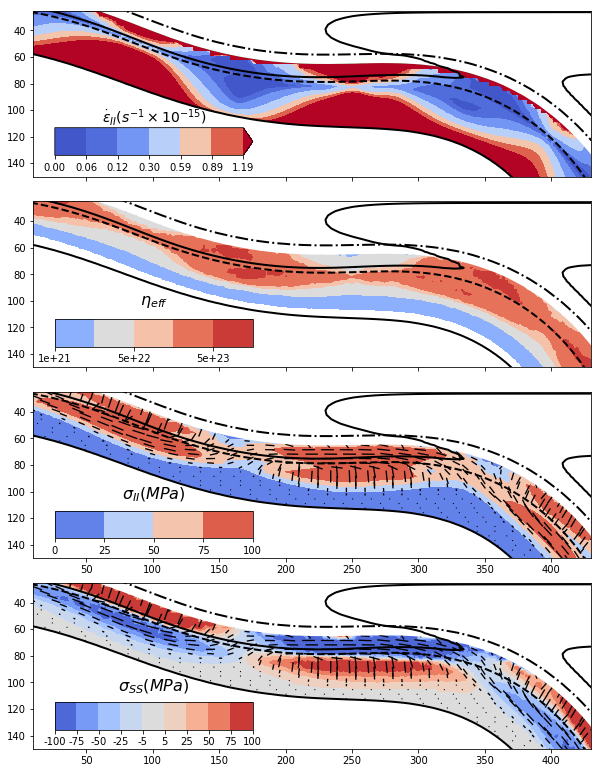

In [108]:

fig = plt.figure(figsize=(10, 14)) 
gs = gridspec.GridSpec(4, 1, height_ratios=[1, 1, 1, 1]) 
gs.update(wspace=0.01, hspace=0.01) # set the spacing between axes. 

########################

ax0 = plt.subplot(gs[0])

srLevels = np.round(np.array([0., 500,  1000,  2500, 5000,7500,  1e4])*srfixscale, 2)

cb0 = ax0.tricontourf((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
                truncStrain[:,0]*srfixscale,
                vmin =1*srfixscale, vmax=1e4*srfixscale,
                levels = srLevels,
                    cmap='coolwarm', 
                   extend='max')


mask = dimIntData0[:,1] <78.

ax0.fill_between(dimIntData0[mask,0] - trenchLoc, dimIntData0[mask,1]  , 
                 dimIntData[mask,1], facecolor='green', alpha=0.75, label = 'subduction interface')

ax0.fill_between(dimIntData[indexWedge:,0] - trenchLoc, 
                 dimIntData[indexWedge:,1], 45*np.ones(len(dimIntData[indexWedge:,1])), 
                 facecolor='gray', alpha=0.9) 

#top of slab
ax0.plot(dimIntData[:,0] - trenchLoc, dimIntData[:,1],c= 'k', ls = '-.', lw= 2, label='slab top')

ax0.plot(2900.*sortedData[:,0] - trenchLoc, 2900 - 2900.*sortedData[:,1], 
         c= 'k', ls = '--', lw = 2, label = 'slab mid-plane')

ax0.tricontour((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
               tempScale*tempData[:,0], levels = [600, 1250], colors= 'k', linewidths = 2.0 )



ax0.fill_between(contour[:,0] - trenchLoc, contour[:,1]  , 
                 200.*np.ones(len(contour[:,1])), facecolor='w', alpha=1)


ax0.fill_between(dimIntData0[:,0] - trenchLoc, dimIntData0[:,1]  , 
                 np.zeros(len(dimIntData[:,1])), facecolor='w', alpha=1)


#ax1.hlines(75, -650 - trenchLoc, 10 - trenchLoc)
ax0.set_xlim(-500 - trenchLoc, -80 - trenchLoc)
ax0.set_ylim(150, 25)

ax0.set_aspect('equal')
ax0.set_xticklabels([])




ax1 = plt.subplot(gs[1])



viscLevs =  np.array([10, 100, 500, 1000, 5000, 7000])*1e20
#viscLevs =  np.array([0.1, 10, 100, 500, 1000, 5000, 0.9e5])*1e20

cb1 = ax1.tricontourf((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
                viscData[:,0]*1e20, 
                cmap='coolwarm',
                levels = viscLevs,
                vmin = 1e20*1e1, vmax = 1e20*9e3,
                norm = LogNorm(), alpha = 1.0)




#top of slab
ax1.plot(dimIntData[:,0] - trenchLoc, dimIntData[:,1],c= 'k', ls = '-.', lw= 2, label='slab top')

ax1.plot(2900.*sortedData[:,0] - trenchLoc, 2900 - 2900.*sortedData[:,1], 
         c= 'k', ls = '--', lw = 2, label = 'slab mid-plane')

ax1.tricontour((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
               tempScale*tempData[:,0], levels = [600, 1250], colors= 'k', linewidths = 2.0 )



ax1.fill_between(contour[:,0] - trenchLoc, contour[:,1]  , 
                 200.*np.ones(len(contour[:,1])), facecolor='w', alpha=1)


ax1.fill_between(dimIntData0[:,0] - trenchLoc, dimIntData0[:,1]  , 
                 np.zeros(len(dimIntData[:,1])), facecolor='w', alpha=1)


ax1.set_xlim(-500 - trenchLoc, -80 - trenchLoc)
ax1.set_ylim(150, 25)
ax1.set_aspect('equal')
ax1.set_xticklabels([])

ax2 = plt.subplot(gs[2])


cb2 = ax2.tricontourf((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
                stressInvData[:,0]*stressScale, 
                vmax = 100, vmin = 0,
                   levels= [0, 25, 50, 75, 100],
                    cmap='coolwarm')

Q1 = ax2.quiver((2900*meshData[tempMask,0][::qn]) - trenchLoc, 2900*(1. - meshData[tempMask,1][::qn]), 
                -1.*stressScale*stressInvData[tempMask,0][::qn]*eigData[tempMask,1][::qn],
                stressScale*stressInvData[tempMask,0][::qn]*eigData[tempMask,0][::qn], 
              headlength=0,headaxislength=0,units='xy', width=1., pivot='middle', 
               scale=10., color = 'k')

#top of slab
ax2.plot(dimIntData[:,0] - trenchLoc, dimIntData[:,1],c= 'k', ls = '-.', lw= 2, label='slab top')

ax2.plot(2900.*sortedData[:,0] - trenchLoc, 2900 - 2900.*sortedData[:,1], 
         c= 'k', ls = '--', lw = 2, label = 'slab mid-plane')

ax2.tricontour((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
               tempScale*tempData[:,0], levels = [600, 1250], colors= 'k', linewidths = 2.0 )



ax2.fill_between(contour[:,0] - trenchLoc, contour[:,1]  , 
                 200.*np.ones(len(contour[:,1])), facecolor='w', alpha=1)


ax2.fill_between(dimIntData0[:,0] - trenchLoc, dimIntData0[:,1]  , 
                 np.zeros(len(dimIntData[:,1])), facecolor='w', alpha=1)

ax2.set_xlim(-500 - trenchLoc, -80 - trenchLoc)
ax2.set_ylim(150, 25)
ax2.set_aspect('equal')


ax3 = plt.subplot(gs[3])


#top of slab


cb3 = ax3.tricontourf((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  -1.*stressData[:,0]*stressScale, 
                vmax = 100, vmin = -100,
                levels = [-100, -75, -50, -25,-5, 5, 25, 50, 75, 100],
                      cmap='coolwarm')


ax3.plot(dimIntData[:,0] - trenchLoc, dimIntData[:,1],c= 'k', ls = '-.', lw= 2, label='slab top')

ax3.plot(2900.*sortedData[:,0] - trenchLoc, 2900 - 2900.*sortedData[:,1], 
         c= 'k', ls = '--', lw = 2, label = 'slab mid-plane')

ax3.tricontour((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
               tempScale*tempData[:,0], levels = [600, 1250], colors= 'k', linewidths = 2.0 )

Q2 = ax3.quiver((2900*meshData[tempMask,0][::qn]) - trenchLoc, 2900*(1. - meshData[tempMask,1][::qn]), 
                -1.*stressScale*stressInvData[tempMask,0][::qn]*eigData[tempMask,1][::qn],
                stressScale*stressInvData[tempMask,0][::qn]*eigData[tempMask,0][::qn], 
              headlength=0,headaxislength=0,units='xy', width=1., pivot='middle', 
               scale=10., color = 'k')


ax3.fill_between(contour[:,0] - trenchLoc, contour[:,1]  , 
                 200.*np.ones(len(contour[:,1])), facecolor='w', alpha=1)


ax3.fill_between(dimIntData0[:,0] - trenchLoc, dimIntData0[:,1]  , 
                 np.zeros(len(dimIntData[:,1])), facecolor='w', alpha=1)

ax3.set_xlim(-500 - trenchLoc, -80 - trenchLoc)
ax3.set_ylim(150, 25)
ax3.set_aspect('equal')



#colourbar axes

#cbaxes = fig.add_axes([0.4, 0.4, 0.1, 0.1], zorder = 1000) 
cbaxes = fig.add_axes([0.155, 0.725, 0.275, 0.0275]) 
cb0 = colorbar(cb0, cax = cbaxes, orientation="horizontal") 
cb0.set_label(r'$\dot \epsilon_{II} (s^{-1}\times 10^{-15})$', size= 14, labelpad=-65)
#cbaxes.tick_params(labelsize=5)

cbaxes1 = fig.add_axes([0.155, 0.535, 0.275, 0.0275])
#cbaxes1 = fig.add_axes([0.155, 0.555, 0.275, 0.0275]) 
cb1 = colorbar(cb1, cax = cbaxes1, orientation="horizontal")
cb1.set_ticks(viscLevs[::2])
cb1.set_ticklabels(viscLevs[::2])
cb1.set_label(r'$\eta_{eff}$', size= 16, labelpad=-70)

labels = cbaxes1.get_xticklabels() 
for label in labels: 
    label.set_rotation(0)
    label.set_fontsize(10)


cbaxes2 = fig.add_axes([0.155, 0.345, 0.275, 0.0275]) 
cb2 = colorbar(cb2, cax = cbaxes2, orientation="horizontal") 
cb2.set_ticks([0, 25, 50, 75, 100])
cb2.set_ticklabels([0, 25, 50, 75, 100])
cb2.set_label(r'$\sigma_{II} (MPa)$', size= 16, labelpad=-70)


cbaxes3 = fig.add_axes([0.155, 0.155, 0.275, 0.0275]) 
cb3 = colorbar(cb3, cax = cbaxes3, orientation="horizontal") 
cb3.set_ticks([-100, -75, -50, -25,-5, 5, 25, 50, 75, 100])
cb3.set_ticklabels([-100, -75, -50, -25,-5, 5, 25, 50, 75, 100])
cb3.set_label(r'$\sigma_{SS} (MPa)$', size= 16, labelpad=-70)


In [109]:
#cb1.set_ticklabels?

In [110]:
#fig.savefig('strain_3panel.png', dpi=300, bbox_inches='tight')

In [1]:
## Plot difference between sigSS, sigII

(200, -0.5)

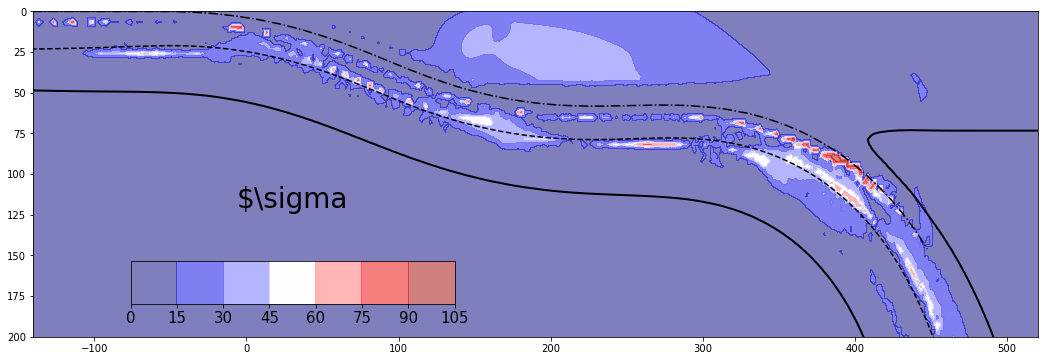

In [290]:
import matplotlib.colors as colors
#stressLevels = [-100., -90,  -75.,  -55.,  -25.,  -10, 10,  25.,   55.,   75., 90., 100.]

fig, ax = plt.subplots(figsize=(18, 6))

cb = ax.tricontourf((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
                np.abs((np.abs(stressData[:,0]) - stressInvData[:,0] )*stressScale), 
                    cmap='seismic', alpha=.5)

cbaxes = fig.add_axes([0.2, 0.2, 0.25, 0.1]) 
cb1 = colorbar(cb, cax = cbaxes, orientation="horizontal") 
#cb1.set_label(r'$\sigma_{ss} =  (\sigma_{ij} \cdot \hat s)\cdot \hat s$ (MPa)', size= 28, labelpad=-140)
cb1.set_label(r'$\sigma$', size= 28, labelpad=-140)
#cb1.set_ticks(stressLevels[:])
cbaxes.tick_params(labelsize=15)


ax.tricontour((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
               tempScale*tempData[:,0], levels = [1250], colors= 'k', linewidths = 2.0 )

#top of slab
ax.plot(dimIntData[:,0] - trenchLoc, dimIntData[:,1],c= 'k', ls = '-.', lw= 1.5, label='slab top')

#midplane
ax.plot(2900.*sortedData[:,0] - trenchLoc, 2900 - 2900.*sortedData[:,1], 
         c= 'k', ls = '--', lw = 1.5, label = 'slab mid-plane')

#ax1.hlines(75, -650 - trenchLoc, 10 - trenchLoc)
ax.set_xlim(-650 - trenchLoc, 10 - trenchLoc)
ax.set_ylim(200, -0.5)



## 4 panel image

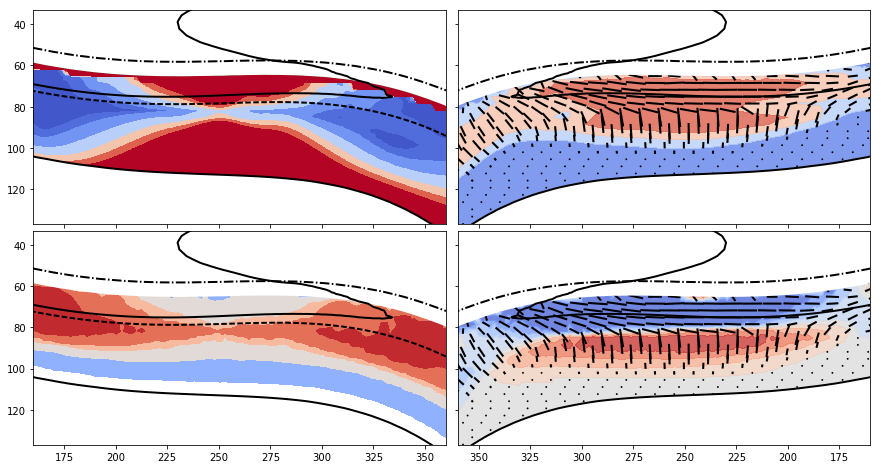

In [62]:
fig, ax = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(15,8))

fig.subplots_adjust(hspace=0.03, wspace=0.03)

qn = 4

########################


srLevels = [0., 500,  1000,  2500, 5000,7500,  1e4]

cb0 = ax[0,0].tricontourf((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
                truncStrain[:,0],
                vmin =1, vmax=1e4,
                levels = srLevels,
                    cmap='coolwarm', 
                   extend='max')


mask = dimIntData0[:,1] <78.

ax[0,0].fill_between(dimIntData0[mask,0] - trenchLoc, dimIntData0[mask,1]  , 
                 dimIntData[mask,1], facecolor='green', alpha=0.75, label = 'subduction interface')

ax[0,0].fill_between(dimIntData[indexWedge:,0] - trenchLoc, 
                 dimIntData[indexWedge:,1], 45*np.ones(len(dimIntData[indexWedge:,1])), 
                 facecolor='gray', alpha=0.9) 

#top of slab
ax[0,0].plot(dimIntData[:,0] - trenchLoc, dimIntData[:,1],c= 'k', ls = '-.', lw= 2, label='slab top')

ax[0,0].plot(2900.*sortedData[:,0] - trenchLoc, 2900 - 2900.*sortedData[:,1], 
         c= 'k', ls = '--', lw = 2, label = 'slab mid-plane')

ax[0,0].tricontour((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
               tempScale*tempData[:,0], levels = [600, 1250], colors= 'k', linewidths = 2.0 )



ax[0,0].fill_between(contour[:,0] - trenchLoc, contour[:,1]  , 
                 200.*np.ones(len(contour[:,1])), facecolor='w', alpha=1)


ax[0,0].fill_between(dimIntData0[:,0] - trenchLoc, dimIntData0[:,1]  , 
                 np.zeros(len(dimIntData[:,1])), facecolor='w', alpha=1)


ax[0,0].set_xlim(-350 - trenchLoc, -150 - trenchLoc)
ax[0,0].set_ylim(130, 40)
ax[0,0].set_aspect('equal')







viscLevs =  [10, 100, 500, 1000, 4000, 7000]
cb1 = ax[1,0].tricontourf((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
                viscData[:,0], 
                cmap='coolwarm',
                levels = viscLevs,
                vmin = 1e1, vmax = 7e3,
                    norm = LogNorm())




#top of slab
ax[1,0].plot(dimIntData[:,0] - trenchLoc, dimIntData[:,1],c= 'k', ls = '-.', lw= 2, label='slab top')

ax[1,0].plot(2900.*sortedData[:,0] - trenchLoc, 2900 - 2900.*sortedData[:,1], 
         c= 'k', ls = '--', lw = 2, label = 'slab mid-plane')

ax[1,0].tricontour((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
               tempScale*tempData[:,0], levels = [600, 1250], colors= 'k', linewidths = 2.0 )



ax[1,0].fill_between(contour[:,0] - trenchLoc, contour[:,1]  , 
                 200.*np.ones(len(contour[:,1])), facecolor='w', alpha=1)


ax[1,0].fill_between(dimIntData0[:,0] - trenchLoc, dimIntData0[:,1]  , 
                 np.zeros(len(dimIntData[:,1])), facecolor='w', alpha=1)


ax[1,0].set_xlim(-350 - trenchLoc, -150 - trenchLoc)
ax[1,0].set_ylim(130, 40)
ax[1,0].set_aspect('equal')



cb2 = ax[0,1].tricontourf((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
                stressInvData[:,0]*stressScale, 
                vmax = 100, vmin = 0,
                   levels= [0, 25, 50, 75, 100],
                    cmap='coolwarm', 
                         alpha=0.8)

n = 5
Q1 = ax[0,1].quiver((2900*meshData[tempMask,0][::qn]) - trenchLoc, 2900*(1. - meshData[tempMask,1][::qn]), 
                -1.*stressScale*stressInvData[tempMask,0][::qn]*eigData[tempMask,1][::qn],
                stressScale*stressInvData[tempMask,0][::qn]*eigData[tempMask,0][::qn], 
              headlength=0,headaxislength=0,units='xy', width=1., pivot='middle', 
               scale=10., color = 'k')

#top of slab
ax[0,1].plot(dimIntData[:,0] - trenchLoc, dimIntData[:,1],c= 'k', ls = '-.', lw= 2, label='slab top')

#ax[0,1].plot(2900.*sortedData[:,0] - trenchLoc, 2900 - 2900.*sortedData[:,1], 
#         c= 'k', ls = '--', lw = 2, label = 'slab mid-plane')

ax[0,1].tricontour((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
               tempScale*tempData[:,0], levels = [600, 1250], colors= 'k', linewidths = 2.0 )



ax[0,1].fill_between(contour[:,0] - trenchLoc, contour[:,1]  , 
                 200.*np.ones(len(contour[:,1])), facecolor='w', alpha=1)


ax[0,1].fill_between(dimIntData0[:,0] - trenchLoc, dimIntData0[:,1]  , 
                 np.zeros(len(dimIntData[:,1])), facecolor='w', alpha=1)

#ax[0,1].set_xlim(-350 - trenchLoc, -150 - trenchLoc)
ax[0,1].set_xlim( -150 - trenchLoc, -350 - trenchLoc)

ax[0,1].set_ylim(130, 40)
ax[0,1].set_aspect('equal')




#top of slab


cb3 = ax[1,1].tricontourf((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  -1.*stressData[:,0]*stressScale, 
                vmax = 100, vmin = -100,
                levels = [-100, -75, -50, -25,-5, 5, 25, 50, 75, 100],
                      cmap='coolwarm', 
                         alpha=0.8)


ax[1,1].plot(dimIntData[:,0] - trenchLoc, dimIntData[:,1],c= 'k', ls = '-.', lw= 2, label='slab top')

#ax[1,1].plot(2900.*sortedData[:,0] - trenchLoc, 2900 - 2900.*sortedData[:,1], 
#         c= 'k', ls = '--', lw = 2, label = 'slab mid-plane')

ax[1,1].tricontour((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
               tempScale*tempData[:,0], levels = [600, 1250], colors= 'k', linewidths = 2.0 )

Q2 = ax[1,1].quiver((2900*meshData[tempMask,0][::qn]) - trenchLoc, 2900*(1. - meshData[tempMask,1][::qn]), 
                -1.*stressScale*stressInvData[tempMask,0][::qn]*eigData[tempMask,1][::qn],
                stressScale*stressInvData[tempMask,0][::qn]*eigData[tempMask,0][::qn], 
              headlength=0,headaxislength=0,units='xy', width=1., pivot='middle', 
               scale=10., color = 'k')


ax[1,1].fill_between(contour[:,0] - trenchLoc, contour[:,1]  , 
                 200.*np.ones(len(contour[:,1])), facecolor='w', alpha=1)


ax[1,1].fill_between(dimIntData0[:,0] - trenchLoc, dimIntData0[:,1]  , 
                 np.zeros(len(dimIntData[:,1])), facecolor='w', alpha=1)

#ax[1,1].set_xlim(-350 - trenchLoc, -150 - trenchLoc)
ax[1,1].set_xlim( -150 - trenchLoc, -350 - trenchLoc)

ax[1,1].set_ylim(130, 40)
ax[1,1].set_aspect('equal')



#colourbar axes

#cbaxes = fig.add_axes([0.155, 0.55, 0.275, 0.0275]) 
#cb0 = colorbar(cb0, cax = cbaxes, orientation="horizontal") 
#cb0.set_label(r'$_{nd}\dot \epsilon_{II}$', size= 16, labelpad=-70)
#cbaxes.tick_params(labelsize=5)

#cbaxes1 = fig.add_axes([0.155, 0.155, 0.275, 0.0275]) 
#cb1 = colorbar(cb1, cax = cbaxes1, orientation="horizontal")
#cb1.set_ticks(viscLevs)
#cb1.set_ticklabels(viscLevs)
#cb1.set_label(r'$_{nd}\eta_{eff}$', size= 16, labelpad=-70)


#cbaxes2 = fig.add_axes([0.6, 0.55, 0.275, 0.0275]) 
#cb2 = colorbar(cb2, cax = cbaxes2, orientation="horizontal") 
#cb2.set_ticks([0, 25, 50, 75, 100])
#cb2.set_ticklabels([0, 25, 50, 75, 100])
#cb2.set_label(r'$\sigma_{II} (MPa)$', size= 16, labelpad=-70)


#cbaxes3 = fig.add_axes([0.6, 0.155, 0.275, 0.0275]) 
#cb3 = colorbar(cb3, cax = cbaxes3, orientation="horizontal") 
#cb3.set_ticks([-100, -75, -50, -25,-5, 5, 25, 50, 75, 100])
#cb3.set_ticklabels([-100, -75, -50, -25,-5, 5, 25, 50, 75, 100])
#cb3.set_label(r'$\sigma_{SS} (MPa)$', size= 16, labelpad=-70)


In [63]:
#fig.savefig('mexicali.png', dpi=300, bbox_inches='tight')

## Yield Stress

In [ ]:
ySData = 20e6 + 0.1*(pressureOnMesh.data[:,0]*11.890606 +  3300*9.8*2900e3*(1. - meshData[:,1]))

fig, ax = plt.subplots()

cb = ax.tricontourf((2900*meshData[:,0] - trenchLoc), 2900*(1. - meshData[:,1]),  
                ySData, 
                cmap='coolwarm',
                 vmin = 20e6 + 0.1*3300*9.8*0e3, vmax = 20e6 + 0.1*3300*9.8*100e3,
                   extend='both')

#ax1.hlines(75, -650 - trenchLoc, 10 - trenchLoc)
ax.set_xlim(-500 - trenchLoc, -80 - trenchLoc)
ax.set_ylim(200, -0.5)

ax.set_aspect('equal')